## Bewildering Grace probabilities

The Bewildering Grace calculations are based on [this spreadsheet](https://docs.google.com/spreadsheets/d/1IUiYWOHEPQ3E4XI4VkmJCdDBs9bOPdhzLhz2vJb7620/). I've collected the values on the 2021-04-11.

In [1]:
from IPython.display import display
def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

Let us first collect the probabilities of the rolls that we want (for an invidual roll of a Bewildering Grace x4)

In [2]:
probabilities = {
  'jp2' : 0.04,
  'jp5' : 0.02,
  'jp100': 0.001,
  'exp5': 0.02,
  'exp100': 0.001,
}

My understanding is that each Bewildering Grace roll draws one of the possible result with the given probabilities. In other word, probabilities sum.

Let us first compute the probability `p_one` of a desirable event on an invidual roll.

In [3]:
p_one = sum(probabilities.values())

In [4]:
print('{:.2f}%'.format(p_one*100))

8.20%


Now, the probability `p` below is the probability of a desired event on a Bewildering Grace x4 attempt (that is, 4 rolls)

In [5]:
p = 1 - (1 - p_one)**4

In [6]:
print('{:.2f}%'.format(p*100))

28.98%


We can see that 20 attempts are virtually guaranteed to yield a success, so we will use 20 as a bound.

In [7]:
def attempt(n):
  return (1-(1-p)**n)

In [8]:
print('{:.2f}%'.format(attempt(20)*100))

99.89%


Let us now do the same, but excluse JPx2, as this is a slower route

In [10]:
probabilities_good = {
    'jp5': probabilities['jp5'],
    'jp100': probabilities['jp100'],
    'exp5': probabilities['exp5'],
    'exp100': probabilities['exp100'],
}

In [12]:
p_good_one = sum(probabilities_good.values())

In [13]:
print('{:.2f}%'.format(p_good_one*100))

4.20%


In [14]:
p_good = 1 - (1 - p_good_one)**4

In [15]:
print('{:.2f}%'.format(p_good*100))

15.77%


In [17]:
def attempt_good(n):
  return (1-(1-p_good)**n)

In [24]:
probas = [ {'# Attempts': n, 'Probability': attempt(n), 'Quality': 'any'} for n in range(21)]
probas.extend([ {'# Attempts': n, 'Probability': attempt_good(n), 'Quality': 'good'} for n in range(21) ])

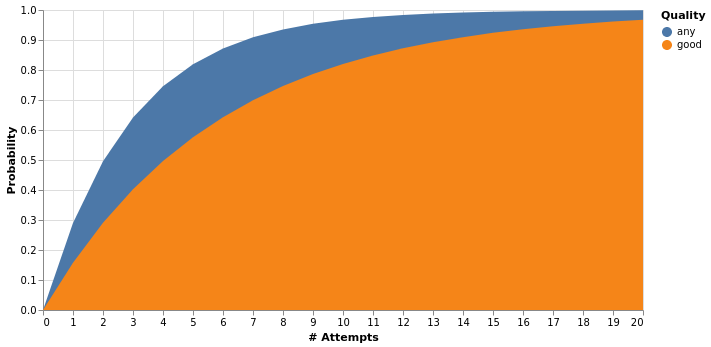

In [26]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
  "height": 300,
  "padding": 5,
  "data": {
    "values": probas
  },
  "mark": "area",
  "encoding": {
    "x": {"field": "# Attempts", "type": "quantitative"},
    "y": {"field": "Probability", "type": "quantitative"},
    "color": {"field": 'Quality'},
  }
})